In [8]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
import numpy as np
import torch
reorder_idx = [0, 13, 14, 15, 20, 1, 2, 3, 16, 4, 5, 6, 17, 10, 11, 12, 19, 7, 8, 9, 18]
def get_joints_3d(joints):
    # * Transfer from UNITY coordinate system
    joints[:, 1:] = -joints[:, 1:]
    joints = joints[reorder_idx]
    joints = joints - joints[9] + np.array([0, 0, 0.5])  # * We use ortho projection, so we need to shift the center of the hand to the origin
    return joints

In [10]:

from scipy.linalg import orthogonal_procrustes
def align_w_scale(mtx1, mtx2):
    """ Align the predicted entity in some optimality sense with the ground truth. """
    # center
    t1 = mtx1.mean(0)
    t2 = mtx2.mean(0)
    mtx1_t = mtx1 - t1
    mtx2_t = mtx2 - t2

    # scale
    s1 = np.linalg.norm(mtx1_t) + 1e-8
    mtx1_t /= s1
    s2 = np.linalg.norm(mtx2_t) + 1e-8
    mtx2_t /= s2

    # orth alignment
    R, s = orthogonal_procrustes(mtx1_t, mtx2_t)

    # apply trafos to the second matrix
    # mtx2_t = np.dot(mtx2_t, R.T) * s
    # mtx2_t = mtx2_t * s1 + t1
    s3 = np.linalg.norm(mtx2) + 1e-8
    mtx2_t = np.dot(mtx2, R.T) / s3

    return mtx2_t

In [11]:
standard_j =  [[1.8155813217163086, 0.15561437606811523, 1.1083018779754639], [2.406423807144165, 0.5383367538452148, 1.304732084274292], [2.731782913208008, 1.172149658203125, 1.335669994354248], [2.681248903274536, 1.7862586975097656, 1.2639415264129639], [2.3304858207702637, 2.234518527984619, 1.1211540699005127], [2.341385841369629, 1.37321138381958, 2.0816190242767334], [2.3071250915527344, 2.0882482528686523, 1.7858655452728271], [2.2974867820739746, 2.293468952178955, 1.3347842693328857], [2.31135630607605, 1.9055771827697754, 1.029522180557251], [1.851935863494873, 1.30698823928833, 2.1360342502593994], [1.8758153915405273, 2.124051094055176, 2.5652201175689697], [1.973258376121521, 2.431856632232666, 2.1032679080963135], [2.0731117725372314, 2.644174098968506, 1.616095781326294], [1.471063256263733, 1.2448792457580566, 2.0854008197784424], [1.4334478378295898, 1.9523506164550781, 1.5718071460723877], [1.6441740989685059, 1.7141218185424805, 1.1860997676849365], [1.760351300239563, 1.242896556854248, 1.305544137954712], [1.1308115720748901, 1.1045317649841309, 1.9674842357635498], [1.0435627698898315, 1.6727776527404785, 1.8200523853302002], [1.2601540088653564, 1.6069226264953613, 1.4762027263641357], [1.4999980926513672, 1.5507283210754395, 1.1099226474761963]]
standard_j = np.array(standard_j)

In [6]:
import os 
import pickle5 as pickle

joint_3d = list()
for idx in range(15):
    data_record = pickle.load(open('datasets/DARTset/train/part_%i.pkl' % idx, "rb"))
    for k in range(len(data_record["pose"])):
        joint_3d.append(data_record['joint3d'][k].astype(np.float32))
joint_3d = np.array(joint_3d)
dart_set = np.empty(joint_3d.shape)
for idx, joint in enumerate(joint_3d):
    dart_set[idx] = align_w_scale(standard_j, joint)
dart_set = dart_set - dart_set[:, 0][:, None, :].repeat(21, axis =1)
dart_set = dart_set.reshape(-1, 63)
        


In [7]:
import json
with open('datasets/general_512/annotations/train/CISLAB_train_joint_3d.json', 'r') as f:
    our_pose = json.load(f)
our_pose = [our_pose['0'][i]['world_coord'][:21] for i in our_pose['0'].keys()]
our_pose_data = np.array(our_pose)
our_set = np.empty(our_pose_data.shape)
for idx, joint in enumerate(our_pose_data):
    our_set[idx] = align_w_scale(standard_j, joint)
our_set = our_set - our_set[:, 0][:, None, :].repeat(21, axis =1)
our_set = our_set.reshape(-1, 63)

In [12]:

# with open('datasets/general_512/annotations/train/CISLAB_train_data_update.pkl', 'rb') as f:
#     our_pose = pickle.load(f)
# our_pose = [our_pose[i]['joint_3d'] for i in our_pose.keys()]
# our_set = np.array(our_pose)
# # our_set = np.empty(our_pose_data.shape)
# # for idx, joint in enumerate(our_pose_data):
# #     our_set[idx] = align_w_scale(standard_j, joint)
# # our_set = our_set - our_set[:, 0][:, None, :].repeat(21, axis =1)
# our_set = our_set.reshape(-1, 63)
# our_set.shape

In [13]:
import json
with open('datasets/frei_test/evaluation_xyz.json') as f:
    frei_joint = json.load(f)
frei_joint = np.array(frei_joint)
frei_set = np.empty(frei_joint.shape)
for idx, joint in enumerate(frei_joint):
    frei_set[idx] = align_w_scale(standard_j, joint)
frei_set = frei_set - frei_set[:, 0][:, None, :].repeat(21, axis =1)
frei_set = frei_set.reshape(-1, 63)

/home/jeongho/miniconda3/envs/Pose/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jeongho/miniconda3/envs/Pose/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


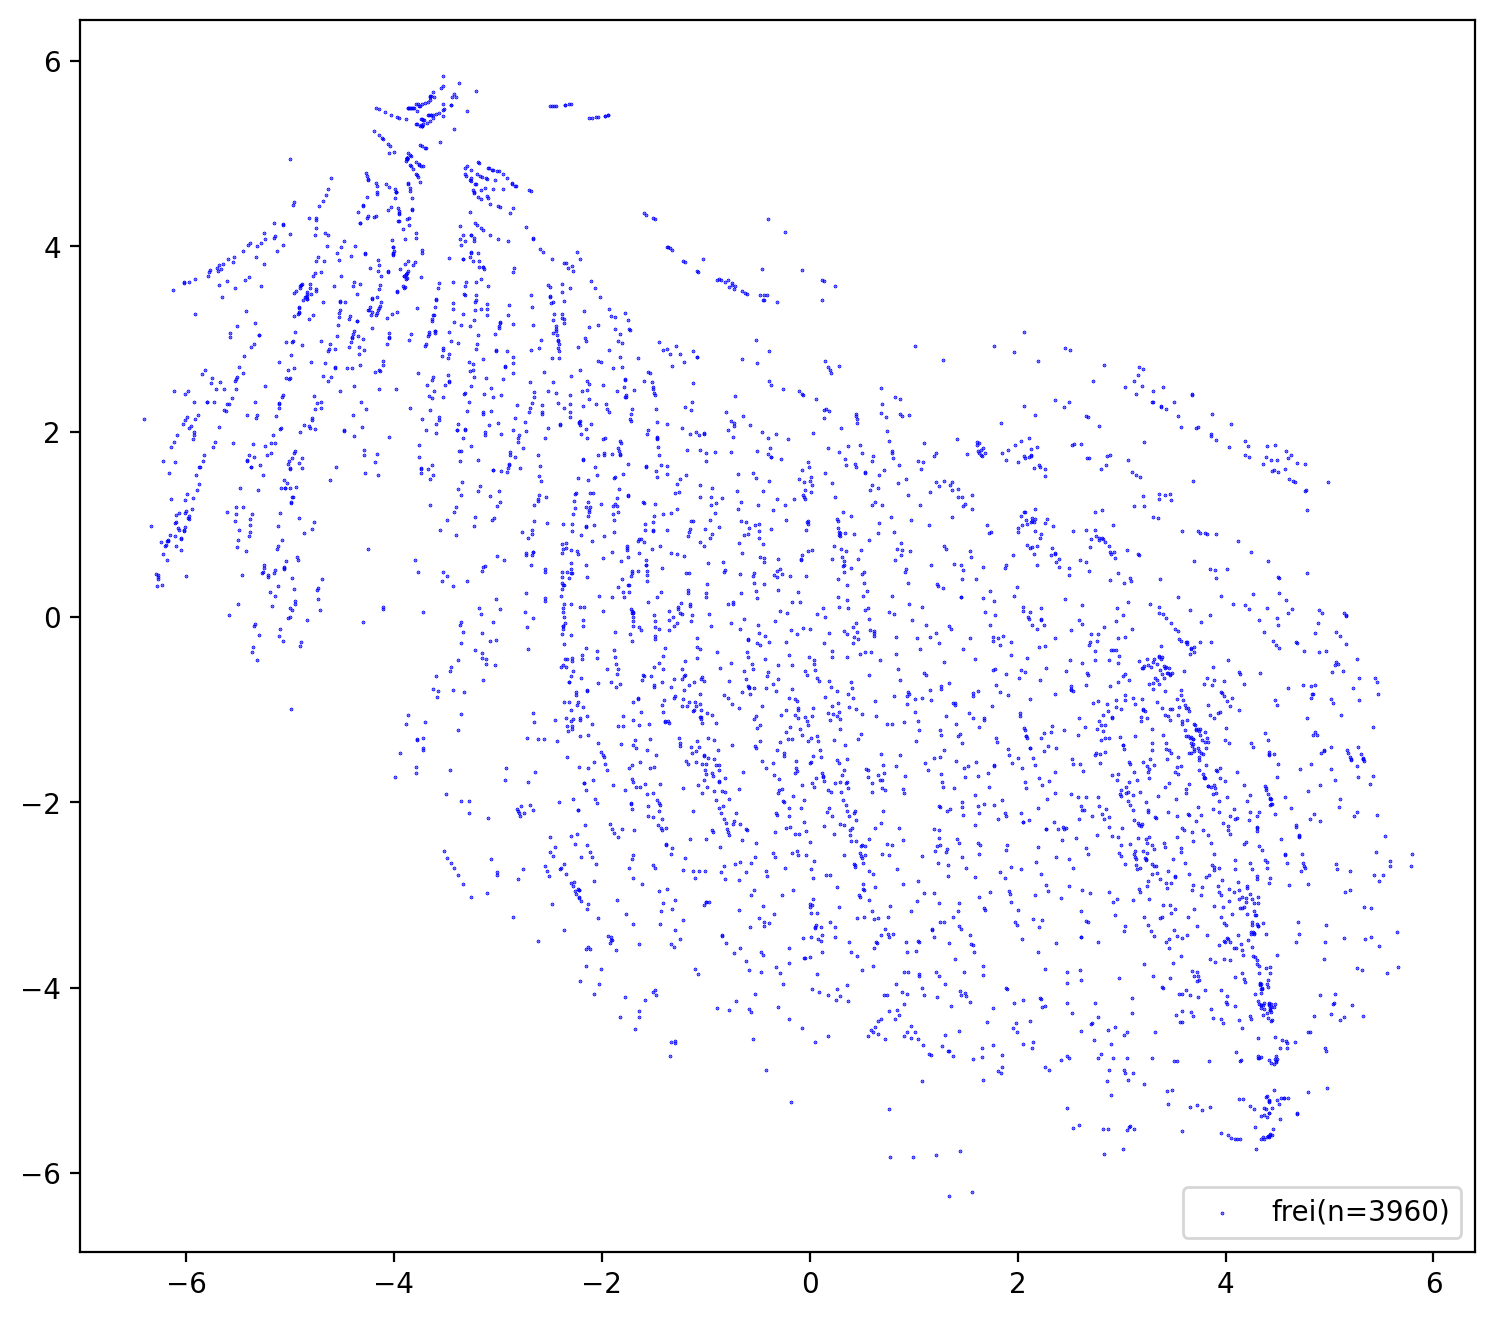

In [15]:
n_components = 2
model = TSNE(n_components = n_components, perplexity = 1200)

X_embedded = model.fit_transform(frei_set)

plt.figure(figsize=(9, 8), dpi =200)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],  s = 0.1, color='blue', alpha = 1, label = 'frei(n=%i)' % len(X_embedded))
plt.legend(loc='lower right')
plt.show()


/home/jeongho/miniconda3/envs/Pose/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jeongho/miniconda3/envs/Pose/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


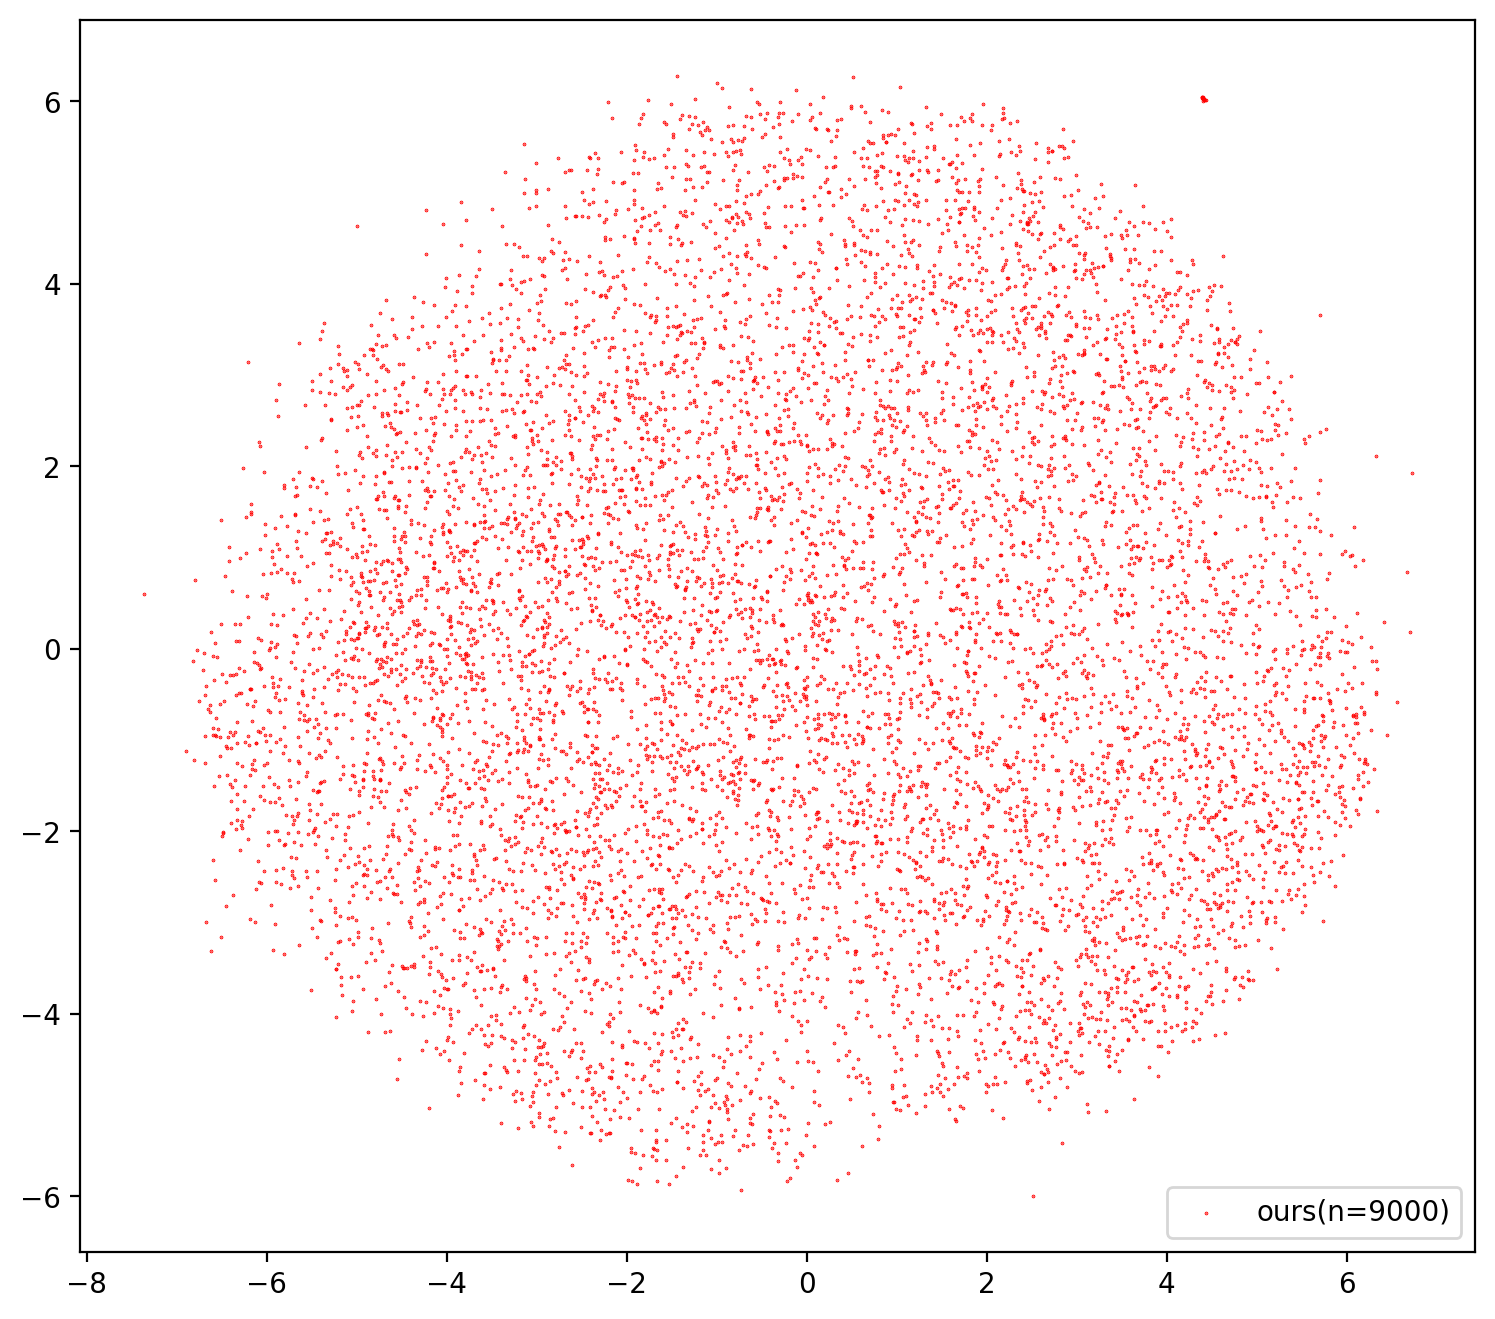

In [18]:
n_components = 2
model = TSNE(n_components = n_components, perplexity = 1200)

Y_embedded = model.fit_transform(our_set)

plt.figure(figsize=(9, 8), dpi =200)
plt.scatter(Y_embedded[:, 0], Y_embedded[:, 1], s = 0.1, color='red', alpha = 1, label = 'ours(n=%i)' % len(Y_embedded))
plt.legend(loc='lower right')
plt.show()

/home/jeongho/miniconda3/envs/Pose/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jeongho/miniconda3/envs/Pose/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


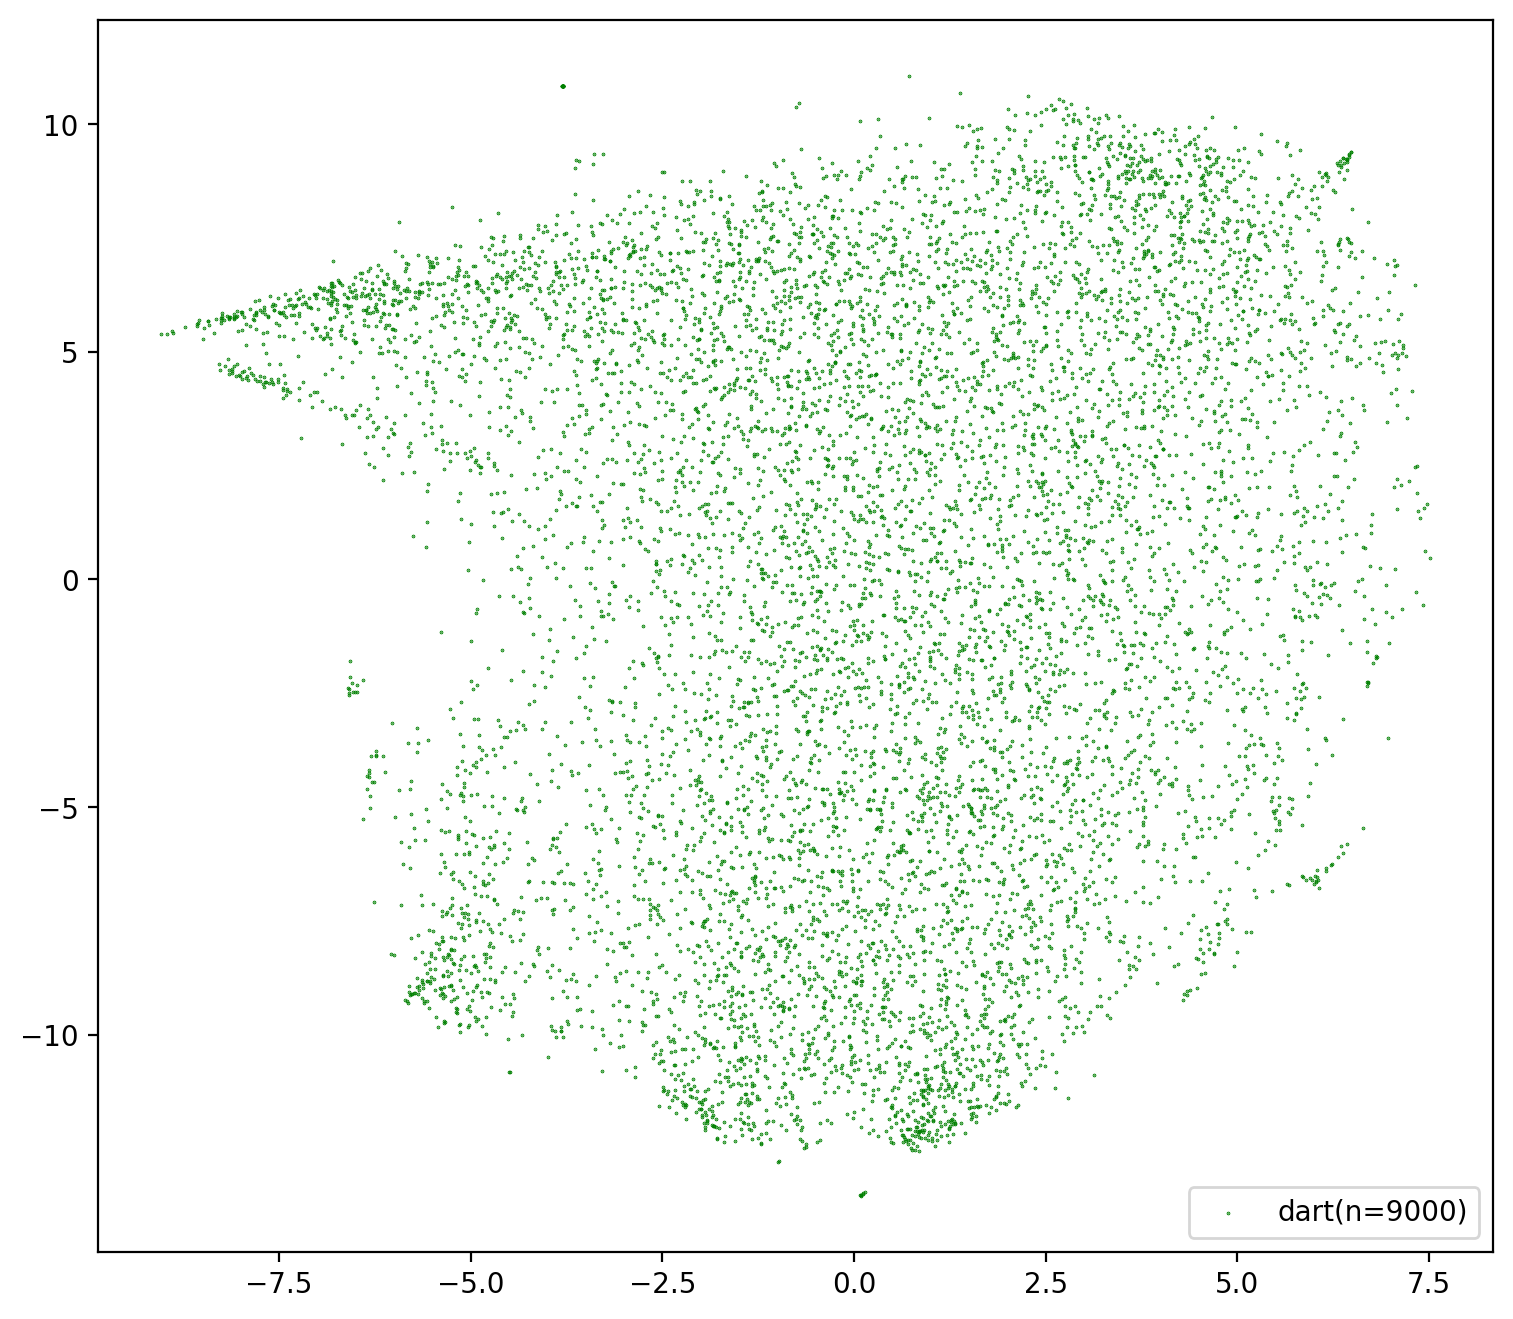

In [17]:
n_components = 2
model = TSNE(n_components = n_components, perplexity = 1200)

Z_embedded = model.fit_transform(dart_set[:9000])

plt.figure(figsize=(9, 8), dpi =200)
plt.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s = 0.1, color='green', alpha = 1, label = 'dart(n=%i)' % len(Z_embedded))
plt.legend(loc='lower right')
plt.show()